In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import os
import warnings
warnings.filterwarnings('ignore')


### Preprocessing

In [2]:
os.makedirs('./output_csv', exist_ok=True)
df = pd.read_csv("../build_dataset/output_csv/bloomberg_data.csv")
df = df.dropna(subset=['Offer To 1st Close'])
df.head(3)

,Issuer Ticker,Issuer Name,Offer Size (M),Sales - 1 Yr Growth,Profit Margin,Return on Assets,Shares Outstanding (M),Offer Price,Offer To 1st Close,Market Cap at Offer (M),...,Filing Term Price Range,Priced Range,Industry Group,Industry Sector,Industry Subgroup,Instit Owner (% Shares Out),Fed Rate,CPI,Consumer Confidence,Unemployment Rate
0,AWE US,New Cingular Wireless Services Inc,10620.00,NaN,NaN,0.075987,360.0,29.5,7.838983,10620.0,...,26.00 - 32.00,Priced Within Range,Telecommunications,Communications,Cellular Telecom,0.000341,6.17,0.058411,109.2,3.8
1,3527578Q US,Agere Systems Inc,4140.00,-6.3,1.2,3.300000,600.0,6.0,0.333333,3600.0,...,6.00 - 7.00,Priced Within Range,Semiconductors,Technology,Electronic Compo-Semicon,NaN,5.59,0.227531,91.5,4.3
2,BGPTQ US,BearingPoint Inc,2328.38,-7.4,-1.0,-1.700000,0.0,18.0,30.468750,0.0,...,16.00 - 18.00,Priced Within Range,Commercial Services,"Consumer, Non-cyclical",Consulting Services,0.009101,5.57,0.399772,90.6,4.2


In [3]:
def convert_features(df):
    """
    Convert the 'Trade Date (US)' column to separate columns for
    month, day, and year, and drop the original 'Trade Date (US)' column.

    Also, convert Offer To 1st Close to a binary classification (Underpriced
    column) and drop original column.
    """
    df['Trade Date (US)'] = pd.to_datetime(df['Trade Date (US)'])
    df['Trade Month'] = df['Trade Date (US)'].dt.month
    df['Trade Day'] = df['Trade Date (US)'].dt.day
    df['Trade Year'] = df['Trade Date (US)'].dt.year
    df['Underpriced'] = df['Offer To 1st Close'].apply(lambda x: 1 if x < 0 else 0)  
    df = df.sort_values('Trade Date (US)')
    df['Prev_5_IPOs_Underpriced'] = df['Underpriced'].shift(1).rolling(window=5, min_periods=1).mean()
    df['Prev_5_IPOs_Underpriced'] = df['Prev_5_IPOs_Underpriced'].apply(lambda x: 1 if x >= 0.6 else 0)
    df.drop(columns=['Trade Date (US)'], inplace=True)
    df.drop(columns=['Offer To 1st Close'], inplace=True)
    return df


df_convert_features = convert_features(df)

In [4]:
def drop_columns(columns,df):
    """
    Drop the specified columns from the DataFrame.
    """
    df = df.drop(columns=columns)
    return df

df_drop_columns = drop_columns(['Issuer Ticker',
                                'Issuer Name',
                                'Filing Term Price Range',
                                'cusip',
                                'Priced Range'],
                                df_convert_features)

In [5]:
df_drop_columns['Industry Sector'].unique()

array(['Energy', 'Technology', 'Communications', 'Consumer, Non-cyclical',
       'Industrial', 'Financial', 'Utilities', 'Consumer, Cyclical',
       'Basic Materials', 'Funds', 'Government', 'Diversified'],
      dtype=object)

In [6]:
def encoding(df, filter_sector=False):
    """
    Split the DataFrame into development and testing sets, using stratified sampling. 
    
    Fill missing values with the mode for categorical 
    columns and the mean for numerical columns.

    Encode columns in the DataFrame: 

      - Categorical columns are encoded using OneHotEncoder.
      - Numerical columns are scaled using StandardScaler.
      - Ordinal columns are encoded using OrdinalEncoder.

    Create df_dev and df_test using the transformed features.
    """

    if filter_sector:
        df = df[df['Industry Sector'].isin(filter_sector)]

    X = df.drop(columns=['Underpriced'])
    y = df['Underpriced']

    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    for col in X_dev.columns:
        if col in ['Trade Month', 'Trade Day', 'Trade Year']:
            X_dev[col] = X_dev[col].fillna(X_dev[col].mode()[0])
            X_test[col] = X_test[col].fillna(X_dev[col].mode()[0])
        elif X_dev[col].dtype == 'object':
            X_dev[col] = X_dev[col].fillna(X_dev[col].mode()[0])
            X_test[col] = X_test[col].fillna(X_dev[col].mode()[0])
        else:
            X_dev[col] = X_dev[col].fillna(X_dev[col].mean())
            X_test[col] = X_test[col].fillna(X_test[col].mean())

    oe_columns = ['Trade Month', 'Trade Day', 'Trade Year'] 
    ohe_columns = ['Industry Sector', 'Industry Group', 'Industry Subgroup']
    ss_columns = [col for col in X.select_dtypes(exclude=['object']).columns if col not in oe_columns]

    oe = OrdinalEncoder()
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ss = StandardScaler()

    preprocess = ColumnTransformer(transformers=[
        ('ohe', ohe, ohe_columns),
        ('ss', ss, ss_columns),
        ('oe', oe, oe_columns)
    ], remainder='passthrough')

    transformed_dev = preprocess.fit_transform(X_dev)
    transformed_test = preprocess.transform(X_test)

    features = preprocess.get_feature_names_out()

    df_dev = pd.DataFrame(transformed_dev, columns=features)
    df_test = pd.DataFrame(transformed_test, columns=features)

    df_dev['Underpriced'] = y_dev.reset_index(drop=True)
    df_test['Underpriced'] = y_test.reset_index(drop=True)

    assert not df_dev.isnull().any().any(), "Missing values found in development set"
    assert not df_test.isnull().any().any(), "Missing values found in test set"
    assert len(df_dev.columns) == len(df_test.columns), "Mismatch in number of features"
    assert 'Underpriced' in df_dev.columns and 'Underpriced' in df_test.columns, "Target column missing"
                
    return df_dev, df_test

df_dev_encoding, df_test_encoding = encoding(df_drop_columns, filter_sector=['Consumer, Non-cyclical', 'Consumer, Cyclical'])

In [7]:
def show_feature_importances(df_dev):
    """
    Calculate feature importance using a simple model
    """
    X_dev = df_dev.drop(columns=['Underpriced'])
    y_dev = df_dev['Underpriced']
    
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_dev, y_dev)
    importances = pd.Series(rf.feature_importances_, index=X_dev.columns)
    print("\nFeature Importances:")
    print(importances.sort_values(ascending=False).head(10))

show_feature_importances(df_dev_encoding)


Feature Importances:
ss__Offer Size (M)                 0.068570
ss__Shares Outstanding (M)         0.062180
ss__Market Cap at Offer (M)        0.058491
ss__Return on Assets               0.054833
ss__Instit Owner (Shares Held)     0.054071
ss__CPI                            0.051407
ss__Offer Price                    0.050677
ss__Consumer Confidence            0.050259
ss__Instit Owner (% Shares Out)    0.049855
ss__Cash Flow per Share            0.047364
dtype: float64


In [8]:
def check_correlation(df_dev, df_test, outfile):
    """
    Check correlation in the X_dev column and drop highly correlated features.
    """

    X_dev = df_dev.drop(columns=['Underpriced'])
    corr_matrix = X_dev.corr().abs()
    
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]
    
    X_dev_reduced = X_dev.drop(columns=to_drop)
    X_test_reduced = df_test.drop(columns=['Underpriced']).drop(columns=to_drop)

    df_dev = pd.concat([X_dev_reduced, df_dev['Underpriced'].reset_index(drop=True)], axis=1)
    df_test = pd.concat([X_test_reduced, df_test['Underpriced'].reset_index(drop=True)], axis=1)

    print(f"Removed {len(to_drop)} correlated features.")
    df_test.to_csv(outfile, index=False)

    return df_dev, df_test

df_dev_correlation, df_test_correlation = check_correlation(df_dev_encoding, df_test_encoding, './output_csv/Final_Output_Class_test.csv')

Removed 10 correlated features.


Underpriced
0    1125
1     350
Name: count, dtype: int64

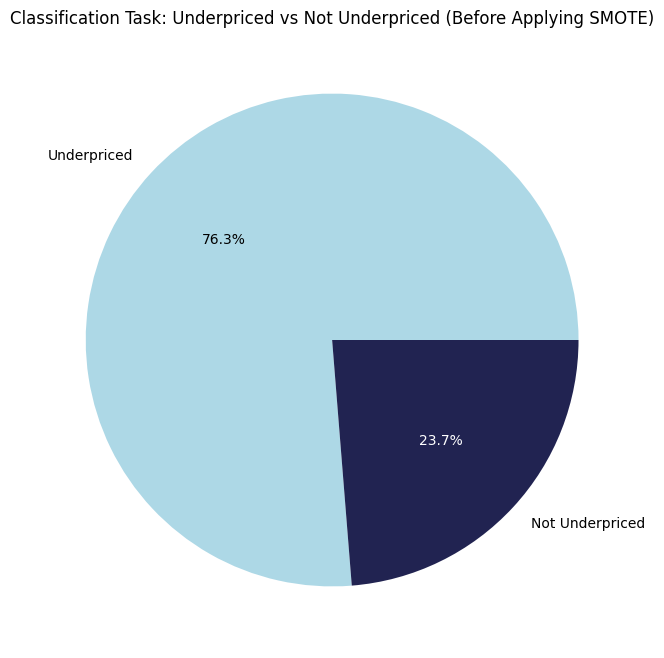

In [9]:
def display_distribution(df_dev_correlation):
    """
    Displaying pie plot to show target data imbalance.
    """
    df = df_dev_correlation.copy()
    plt.figure(figsize=(8, 8))
    underpriced_counts = df['Underpriced'].value_counts()
    display(underpriced_counts)
    labels = ['Underpriced', 'Not Underpriced']
    colors = ['lightblue', '#212351']

    _, _, autotexts = plt.pie(
        underpriced_counts, labels=labels, colors=colors,
        autopct='%1.1f%%', textprops={'color': 'black'}
    )

    for i, autotext in enumerate(autotexts):
        if colors[i] == '#212351':
            autotext.set_color('white')

    plt.title('Classification Task: Underpriced vs Not Underpriced (Before Applying SMOTE)')
    plt.show()
    
display_distribution(df_dev_correlation)

In [10]:
def checkimbalance(df, outfile):
    """
    Checking imbalance in the target data. 

    If imbalance, resample using SMOTE.
    """
    X_dev = df.drop(columns=['Underpriced'])
    y_dev = df['Underpriced']

    label_count_norm = df['Underpriced'].value_counts(normalize=True)
    label_count = df['Underpriced'].value_counts()
    print(f"Class distribution (normalized):\n{label_count_norm}\n")
    print(f"Class distribution:\n{label_count}\n")


    imbalance = abs(label_count_norm[0] - 0.5) > 0.1

    if imbalance:
        print('The data is imbalanced. Applying SMOTE...')
        sampler = SMOTE(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_dev, y_dev)
        df_final = pd.concat([X_resampled, y_resampled], axis=1)
        df_final.to_csv(outfile, index=False)
        print(f'The initial dataset had {y_dev.shape[0]} rows')
        print(f'The resampled dataset has {y_resampled.shape[0]} rows')
        print(f'Resampled feature matrix shape: {X_resampled.shape}')
        return df_final
    else:
        print('The data is balanced. No resampling applied.')
        return df
    
df_dev_resampled = checkimbalance(df_dev_correlation, './output_csv/Final_Output_Class_dev.csv')

Class distribution (normalized):
Underpriced
0    0.762712
1    0.237288
Name: proportion, dtype: float64

Class distribution:
Underpriced
0    1125
1     350
Name: count, dtype: int64

The data is imbalanced. Applying SMOTE...
The initial dataset had 1475 rows
The resampled dataset has 2250 rows
Resampled feature matrix shape: (2250, 156)


In [11]:
def checkimbalance_undersampling(df, outfile):
    """
    Checking imbalance in the target data. 

    If imbalance, resample using SMOTE.
    """
    X_dev = df.drop(columns=['Underpriced'])
    y_dev = df['Underpriced']

    label_count_norm = df['Underpriced'].value_counts(normalize=True)
    label_count = df['Underpriced'].value_counts()
    print(f"Class distribution (normalized):\n{label_count_norm}\n")
    print(f"Class distribution:\n{label_count}\n")


    imbalance = abs(label_count_norm[0] - 0.5) > 0.1

    if imbalance:
        print('The data is imbalanced. Applying UnderSampling...')
        sampler = RandomUnderSampler(sampling_strategy=0.8, random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_dev, y_dev)
        df_final = pd.concat([pd.DataFrame(X_resampled, columns=X_dev.columns),
                              pd.Series(y_resampled, name='Underpriced')], axis=1)
        df_final.to_csv(outfile, index=False)
        print(f'The initial dataset had {y_dev.shape[0]} rows')
        print(f'The resampled dataset has {y_resampled.shape[0]} rows')
        print(f'Resampled feature matrix shape: {X_resampled.shape}')
        return df_final
    else:
        print('The data is balanced. No resampling applied.')
        return df

df_dev_resampled_under = checkimbalance_undersampling(df_dev_correlation, './output_csv/Final_Output_Class_dev_under.csv')

Class distribution (normalized):
Underpriced
0    0.762712
1    0.237288
Name: proportion, dtype: float64

Class distribution:
Underpriced
0    1125
1     350
Name: count, dtype: int64

The data is imbalanced. Applying UnderSampling...
The initial dataset had 1475 rows
The resampled dataset has 787 rows
Resampled feature matrix shape: (787, 156)


In [12]:
def smote_tomek(df, outfile):
    """
    Checking imbalance in the target data. 

    If imbalance, resample using SMOTE.
    """
    X_dev = df.drop(columns=['Underpriced'])
    y_dev = df['Underpriced']

    label_count_norm = df['Underpriced'].value_counts(normalize=True)
    label_count = df['Underpriced'].value_counts()
    print(f"Class distribution (normalized):\n{label_count_norm}\n")
    print(f"Class distribution:\n{label_count}\n")


    imbalance = abs(label_count_norm[0] - 0.5) > 0.1

    if imbalance:
        print('The data is imbalanced. Applying SMOTE...')
        sampler = SMOTETomek(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_dev, y_dev)
        df_final = pd.concat([X_resampled, y_resampled], axis=1)
        df_final.to_csv(outfile, index=False)
        print(f'The initial dataset had {y_dev.shape[0]} rows')
        print(f'The resampled dataset has {y_resampled.shape[0]} rows')
        print(f'Resampled feature matrix shape: {X_resampled.shape}')
        return df_final
    else:
        print('The data is balanced. No resampling applied.')
        return df
    
df_dev_resampled_tomek = smote_tomek(df_dev_correlation, './output_csv/Final_Output_Class_dev_tomek.csv')

Class distribution (normalized):
Underpriced
0    0.762712
1    0.237288
Name: proportion, dtype: float64

Class distribution:
Underpriced
0    1125
1     350
Name: count, dtype: int64

The data is imbalanced. Applying SMOTE...
The initial dataset had 1475 rows
The resampled dataset has 2206 rows
Resampled feature matrix shape: (2206, 156)


### Model Training

In [13]:
def split_data(df, target_col='Underpriced'):
    """
    Preprocess the data with feature engineering and scaling
    """
    X = df.drop(columns=target_col)
    y = df[target_col]
    return X, y

In [14]:
def get_enhanced_model_params():
    """
    Return enhanced classification models with wider search space
    """
    return {
        "Dummy Classifier": {
            "model": DummyClassifier(strategy='most_frequent'),
            "params": {}
        },
        "Logistic Regression": {
            "model": LogisticRegression(solver='liblinear', random_state=42, max_iter=10000, tol=1e-3),
            "params": {
                "C": [0.01, 0.1, 1, 10, 100],
                "penalty": ['l1', 'l2']
            }
        },
        "Ridge Classifier": {
            "model": RidgeClassifier(max_iter=10000, tol=1e-3),
            "params": {
                "alpha": [0.1, 1.0, 10.0]
            }
        },
        "Random Forest Classifier": {
            "model": RandomForestClassifier(random_state=42, n_jobs=-1),
            "params": {
                "n_estimators": [100, 200],
                "max_depth": [None, 10, 20],
                "max_features": ["sqrt", "log2"]
            }
        },
        "K-Nearest Neighbors": {
            "model": KNeighborsClassifier(),
            "params": {
                "n_neighbors": [3, 5, 7],
                "weights": ["uniform", "distance"]
            }
        },
        "Gaussian Naive Bayes": {
            "model": GaussianNB(),
            "params": {
                "var_smoothing": [1e-9, 1e-8, 1e-7]
            }
        },
        "Decision Tree": {
            "model": DecisionTreeClassifier(random_state=42),
            "params": {
                "max_depth": [None, 5, 10, 15],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4]
            }
        },
        "Shallow MLP": {
            "model": MLPClassifier(random_state=42, max_iter=1000, early_stopping=True),
            "params": {
                "hidden_layer_sizes": [(50,), (100,)],
                "alpha": [0.0001, 0.001],
                "activation": ["relu", "tanh"]
            }
        },
        "LightGBM": {
            "model": LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
            "params": {
                "n_estimators": [100, 200],
                "learning_rate": [0.01, 0.1],
                "max_depth": [3, 5, 7],
                "num_leaves": [31, 63]
            }
        },
        "SGD Classifier": {
            "model": SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
            "params": {
                "alpha": [0.0001, 0.001, 0.01],
                "loss": ["hinge", "log_loss"],
                "penalty": ["l2", "l1", "elasticnet"]
            }
        }
    }

In [15]:
def evaluate_models(model_params, X_train, y_train, X_val, y_val):
    """Evaluate classification models with multiple metrics"""
    results = []

    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    total_models = len(model_params)
    print(f"Evaluating {total_models} models...\n")

    for i, (name, mp) in enumerate(model_params.items(), 1):
        print(f"[{i}/{total_models}] Training and evaluating: {name}...", end=" ")

        try:
            if mp["params"]:
                grid = GridSearchCV(
                    mp["model"],
                    mp["params"],
                    cv=skf,
                    scoring='f1',
                    n_jobs=-1,
                    verbose=0
                )
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
                print("✓ (GridSearch complete)")
            else:
                best_model = mp["model"]
                best_model.fit(X_train, y_train)
                print("✓ (No tuning needed)")

            cv_scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='f1')

            y_pred = best_model.predict(X_val)

            acc = accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            precision = precision_score(y_val, y_pred, zero_division=0)
            recall = recall_score(y_val, y_pred, zero_division=0)

            results.append({
                "Model": name,
                "Accuracy": acc,
                "F1 Score": f1,
                "Precision": precision,
                "Recall": recall,
                "CV F1 Mean": cv_scores.mean(),
                "CV F1 Std": cv_scores.std()
            })

            train_sizes, train_scores, val_scores = learning_curve(
                best_model, X_train, y_train, cv=skf, scoring='f1',
                train_sizes=np.linspace(0.1, 1.0, 10)
            )

            plt.figure(figsize=(10, 6))
            plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
            plt.plot(train_sizes, val_scores.mean(axis=1), label='Cross-validation score')
            plt.fill_between(train_sizes,
                           train_scores.mean(axis=1) - train_scores.std(axis=1),
                           train_scores.mean(axis=1) + train_scores.std(axis=1),
                           alpha=0.1)
            plt.fill_between(train_sizes,
                           val_scores.mean(axis=1) - val_scores.std(axis=1),
                           val_scores.mean(axis=1) + val_scores.std(axis=1),
                           alpha=0.1)
            plt.title(f'Learning Curves - {name}')
            plt.xlabel('Training examples')
            plt.ylabel('F1 Score')
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"✗ Error with {name}: {str(e)}")
            continue

    results_df = pd.DataFrame(results)

    top5_models_df = results_df.sort_values(by="F1 Score", ascending=False).head(5).reset_index(drop=True)

    return results_df, top5_models_df

In [16]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(r"[^\w\d_]+", "_", regex=True)
    return df

In [17]:
def evaluate_best_model(model_params, X, y, top5_models_df):
    """
    Evaluate the best model on the test set
    """
    df_test = pd.read_csv('./output_csv/Final_Output_Class_test.csv')
    X_test, y_test = split_data(df_test)
    X_test = clean_column_names(X_test)

    best_model_name = top5_models_df.iloc[0]['Model']
    best_model = model_params[best_model_name]['model']
    best_model.fit(X, y)

    dummy_model = model_params['Dummy Classifier']['model']
    dummy_model.fit(X, y)

    y_pred = best_model.predict(X_test)
    y_pred_dummy = dummy_model.predict(X_test)

    test_metrics = {
        "Model": best_model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "Dummy F1 Score": f1_score(y_test, y_pred_dummy, zero_division=0)
    }

    metrics_df = pd.DataFrame([test_metrics])
    metrics_df.to_csv('./output_csv/best_model_Class_test_results.csv', index=False)

    print("\nTest Set Performance:")
    display(metrics_df)

In [18]:
def main():
    try:
        df_dev = pd.read_csv('./output_csv/Final_Output_Class_dev.csv')
        X, y = split_data(df_dev)
        X = clean_column_names(X)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        model_params = get_enhanced_model_params()
        results_df, top5_models_df = evaluate_models(model_params, X_train, y_train, X_val, y_val)

        print("\nTop 5 Models:")
        display(top5_models_df)
        results_df.to_csv('./output_csv/classification_results.csv', index=False)
        top5_models_df.to_csv('./output_csv/top5_classification_models.csv', index=False)
        evaluate_best_model(model_params, X, y, top5_models_df)
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise

Evaluating 10 models...

[1/10] Training and evaluating: Dummy Classifier... ✓ (No tuning needed)


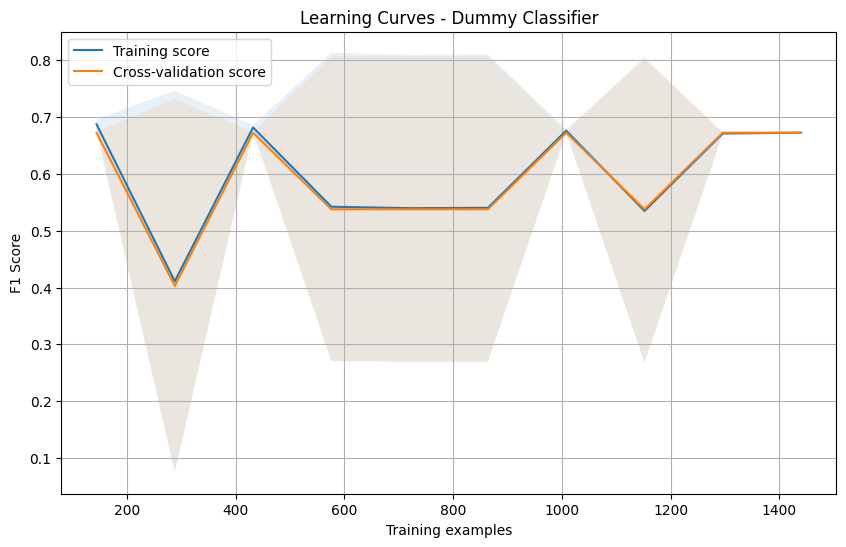

[2/10] Training and evaluating: Logistic Regression... ✓ (GridSearch complete)


In [ ]:
main()